# Final Project Machine Learning Phishing URL


"Highly accurate phishing URL detection based on machine learning," presents a machine learning-based framework for detecting phishing URLs. It highlights the persistent threat of phishing attacks and the limitations of existing detection techniques. The proposed method focuses on URL analysis, using a set of features extracted from URLs to classify them as phishing or legitimate. Experiments on various datasets show the framework's effectiveness, with a notable improvement in accuracy compared to existing methods. The approach avoids relying on third-party services or webpage visits, making it efficient and secure.

In [1]:
pip install pandas scikit-learn numpy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install python-whois


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install numpy seaborn scikit-learn joblib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from urllib.parse import urlparse
import numpy as np
from math import log2
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Read the data

In [6]:
df = pd.read_csv('combined_df.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,url,label
0,www.usaozsazps.com/information,1
1,awrs.cl/wp-content/themes/form/bill.charged.html,1
2,ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...,1
3,wwxhajudjgwjklckvzgs7.firebaseapp.com/,1
4,roomclip.jp,0
...,...,...
91721,optikgeneral.com/Webmail/12/Webmail/webmail.php,1
91722,thegioididong.com,0
91723,pressks.com,0
91724,68.178.168.47/Empresarial/,1


In [7]:
def extract_domain(url):
    """
    Extracts the domain name from a URL.
    """
    first_url = "http://" + url
    parsed_url = urlparse(first_url)
    domain = parsed_url.netloc

    if domain.startswith("www."):
        domain = domain[4:]

    return domain

# Apply the function to extract domains and remove duplicates
unique_domains = set(df['url'].apply(extract_domain))
# Convert the set back to a list if you need list format
unique_domains_list = list(unique_domains)

print(len(unique_domains_list))

74618


# Features

### Features From Urls

In [8]:

# Helper function to calculate the number of times each special character appears in the URL
def count_chars(url, char_list):
    return {f"num_{char}_url": url.count(char) for char in char_list}

# Function to check if an email is present in the URL
def check_email_in_url(url):
    return 1 if "@" in url else 0

# Calculate the length of the top-level domain (TLD)
def tld_length(url):
    domain = urlparse(url).netloc
    try:
        return len(domain.split('.')[-1])  # Assuming the last part after the last dot is the TLD
    except IndexError:
        return 0

# New function to check if "&" is greater than "=" in the URL
def amp_greater_than_equal(url):
    num_amp = url.count("&")
    num_equal = url.count("=")
    return 1 if num_amp > num_equal else 0

# Updated function to extract features from URLs in a DataFrame
def extract_features_from_urls(df):
    def get_features(url):
        special_chars = ['.', '-', '_', '/', '?', '=', '@', '&', '!', ' ', '~', ',', '+', '*', '#', '$', '%']
        features = count_chars(url, special_chars)
        features['length_url'] = len(url)
        features['email_in_url'] = check_email_in_url(url)
        features['num_tld_url'] = tld_length(url)
        # Add the new feature
        features['amp_greater_than_equal'] = amp_greater_than_equal(url)
        return features
    
    # Apply the get_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(get_features(x)))
    return pd.concat([df, features_df], axis=1)


In [9]:
#First, apply URL features extraction
df_features = extract_features_from_urls(df)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

# features from domain

In [10]:
import requests
import re
def get_domain_age(domain):
    # Placeholder URL and key - replace with actual URL and your API key
    api_url = f"https://example-domain-info-service.com/api/lookup?domain={domain}"
    api_key = "your_api_key_here"
    
    headers = {"Authorization": f"Bearer {api_key}"}
    
    try:
        response = requests.get(api_url, headers=headers)
        response.raise_for_status()  # Check for HTTP request errors
        data = response.json()
        # Assuming the service returns a JSON object with a 'creation_date' field
        creation_date = data.get('creation_date', None)
        # Convert 'creation_date' to a datetime object and calculate age
        if creation_date:
            creation_date = pd.to_datetime(creation_date)
            current_date = pd.Timestamp.now()
            domain_age_days = (current_date - creation_date).days
            return domain_age_days
        else:
            return None
    except Exception as e:
        print(f"Error fetching domain age for {domain}: {e}")
        return None


def domain_features(url):
    first_url = "http://" + url
    parsed_url = urlparse(first_url)
    domain = parsed_url.netloc

    if domain.startswith("www."):
        domain = domain[4:]

    # Calculate the number of dots in the domain
    num_dots_dom = domain.count('.')

    # Calculate the number of hyphens in the domain
    num_hyph_dom = domain.count('-')

    # Calculate the number of underscores in the domain
    num_undeline_dom = domain.count('_')

    # Count the number of vowels in the domain
    num_vowels_dom = sum(1 for char in domain if char in 'aeiouAEIOU')

    # Calculate the length of the domain
    length_dom = len(domain)

    # Check if the domain is in IP format
    dom_in_ip = 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", domain) else 0

    # Check for the presence of "server" or "client" in the domain
    server_client_dom = 1 if 'server' in domain or 'client' in domain else 0

    #domain_age_days = get_domain_age(domain)

    # try:
    #     domain_info = whois.whois(domain)
    #     creation_date = domain_info.creation_date
    #     expiration_date = domain_info.expiration_date
        
    #     # Normalize creation and expiration dates if they are in list format or other
    #     if isinstance(creation_date, list):
    #         creation_date = creation_date[0]
    #     if isinstance(expiration_date, list):
    #         expiration_date = expiration_date[0]
        
    #     # Calculate domain age in days
    #     if creation_date and expiration_date:
    #         domain_age_days = (expiration_date - creation_date).days
    #     else:
    #         domain_age_days = None
    # except Exception as e:
    #     domain_age_days = None  # In case of any error, set domain age to None

    # Compile all features into a dictionary
    features = {
        'num_dots_dom': num_dots_dom,
        'num_hyph_dom': num_hyph_dom,
        'num_undeline_dom': num_undeline_dom,
        'num_vowels_dom': num_vowels_dom,
        'length_dom': length_dom,
        'dom_in_ip': dom_in_ip,
        'server_client_dom': server_client_dom,
        #'domain_age_days': domain_age_days,  # Add domain age in days to the features
    }
    
    return features


def features_from_domain(df):
    # Apply the domain_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(domain_features(x)))
    return pd.concat([df, features_df], axis=1)

In [11]:
#Then, apply domain features extraction on the same DataFrame
df_features = features_from_domain(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

### Features Pathname

In [12]:
def extract_pathname_features(url):
    """
    Extracts features from the pathname of a URL.
    """
    first_url = "http://" + url
    pathname = urlparse(first_url).path

    features = {
        'num_dots_path': pathname.count('.'),
        'num_hyph_path': pathname.count('-'),
        'num_undeline_path': pathname.count('_'),
        'num_slash_path': pathname.count('/'),
        'num_question_path': pathname.count('?'),
        'num_equal_path': pathname.count('='),
        'at_sign_path': pathname.count('@'),
        'num_and_path': pathname.count('&'),
        'num_exclamation_path': pathname.count('!'),
        'num_space_path': pathname.count(' '),
        'tilde_path': pathname.count('~'),
        'num_comma_path': pathname.count(','),
        'num_plus_path': pathname.count('+'),
        'num_asterisk_path': pathname.count('*'),
        'num_hash_path': pathname.count('#'),
        'num_dollar_path': pathname.count('$'),
        'num_percent_path': pathname.count('%'),
        'length_path': len(pathname)
    }
    
    return features

def features_from_pathname(df):
    """
    Applies the extract_pathname_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_pathname_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_pathname_features(x)))
    return pd.concat([df, features_df], axis=1)


In [13]:
df_features = features_from_pathname(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

### Features Filename

In [14]:
def extract_filename_features(url):
    """
    Extracts features from the filename of a URL.
    """
    first_url = "http://" + url
    # Parse the URL to get the path
    path = urlparse(first_url).path
    # Extract the filename (assuming the filename is the last part of the path)
    filename = path.split('/')[-1] if '/' in path else path
    
    features = {
        'num_dots_file': filename.count('.'),
        'num_hyph_file': filename.count('-'),
        'num_undeline_file': filename.count('_'),
        'num_equal_file': filename.count('='),
        'at_sign_file': filename.count('@'),
        'num_and_file': filename.count('&'),
        'num_exclamation_file': filename.count('!'),
        'num_space_file': filename.count(' '),
        'tilde_file': filename.count('~'),
        'num_comma_file': filename.count(','),
        'num_plus_file': filename.count('+'),
        'num_percent_file': filename.count('%'),
        'length_file': len(filename)
    }
    
    return features

def features_from_filename(df):
    """
    Applies the extract_filename_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_filename_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_filename_features(x)))
    return pd.concat([df, features_df], axis=1)

In [15]:
df_features = features_from_filename(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

### Features Parameters

In [16]:
from urllib.parse import urlparse, parse_qs
import pandas as pd

def extract_parameters_features(url):
    """
    Extracts features from the parameters of a URL.
    """
    first_url = "http://" + url
    query_string = urlparse(first_url).query
    params = parse_qs(query_string)
    
    # Counting the occurrences of various symbols in the entire query string
    features = {
        'num_dots_param': query_string.count('.'),
        'num_hyph_param': query_string.count('-'),
        'num_undeline_param': query_string.count('_'),
        'num_slash_param': query_string.count('/'),
        'num_questionmark_param': query_string.count('?'),
        'num_equal_param': query_string.count('='),
        'at_sign_param': query_string.count('@'),
        'num_and_param': query_string.count('&'),
        'num_exclamation_param': query_string.count('!'),
        'num_space_param': query_string.count(' '),
        'tilde_param': query_string.count('~'),
        'num_comma_param': query_string.count(','),
        'num_plus_param': query_string.count('+'),
        'num_asterisk_param': query_string.count('*'),
        'num_dollar_param': query_string.count('$'),
        'num_percent_param': query_string.count('%'),
        'length_param': len(query_string),
        'tld_in_param': int(any(part.endswith(('.com', '.org', '.net', '.edu', '.gov')) for part in query_string.split('&'))),
        'num_param': len(params)
    }
    
    return features

def features_from_parameters(df):
    """
    Applies the extract_parameters_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_parameters_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_parameters_features(x)))
    return pd.concat([df, features_df], axis=1)

In [17]:
df_features = features_from_parameters(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [18]:
import joblib

X = df_features.drop(['url', 'label'], axis=1)
y = df_features['label']

# Assuming X is your features and y is your labels
# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# If you need a validation set as well
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

# Feature selection
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

selector = SelectFromModel(forest, prefit=True)
X_important_train = selector.transform(X_train)
X_important_val = selector.transform(X_val)
X_important_test = selector.transform(X_test)

# Saving the necessary objects for later use
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump((X_important_test, y_test), 'test_data.pkl')

/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


['test_data.pkl']

In [19]:
# Get a mask, or integer index, of the features selected
selected_features_mask = selector.get_support()

# Now, print the names of the features selected
selected_feature_names = X_train.columns[selected_features_mask]
print("Selected Features:")
print(selected_feature_names.tolist())

Selected Features:
['num_._url', 'num_-_url', 'num_/_url', 'length_url', 'num_dots_dom', 'num_vowels_dom', 'length_dom', 'num_slash_path', 'length_path', 'length_file']




## Hyperparameter Tuning with GridSearchCV

In this section, we perform hyperparameter tuning for a RandomForestClassifier using GridSearchCV from the scikit-learn library. Hyperparameter tuning is a critical step in the machine learning workflow as it can significantly improve the model's performance by finding the optimal configuration of the model's parameters.

### Step 1: Define the Parameter Grid

We start by defining a grid of hyperparameter values we want to experiment with. The `param_grid` dictionary specifies the parameters to be tested and the range of values for each parameter. In this example, we are tuning two hyperparameters:

- `n_estimators`: The number of trees in the forest. We test three values: 100, 200, and 300.
- `max_depth`: The maximum depth of the trees. We test four values: None (unlimited depth), 10, al resources.

### Step 2: Initialize GridSearchCV

We initialize a GridSearchCV object with the RandomForestClassifier as the estimator. The `param_grid` is passed along with the number of folds for cross-validation (`cv=5`), enabling parallel execution (`n_jobs=-1`) to speed up the search, and setting `verbose=2` for more detailed logging duuit your problem.

### Step 3: Fit GridSearchCV to the Data

We fit GridSearchCV to the training data (`X_important_train`, `y_train`). This process involves training a RandomForestClassifier for each combination of parameters in the grid, evaluated using cross-validation. The best combination of parameters is determined based on the average cross-validation score.

### Step 4: Evaluate the Best Model

After finding the best hyperparameters, we retrieve the best estimator (`best_forest`) and use it for further predictions or evaluation. Optionally, we save this best model to a file using joblib for future use.

This process of hyperparameter tuning is crucial for optimizing the model's performance and can be applied to virtually any machine learning algorithm. By systematically exploring the parameter space, we can identify the most effective settings for our model and data.


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    # Add more parameters here if you want
}

# Initialize the classifier
# Classification using selected features
forest_important = RandomForestClassifier(n_estimators=100, random_state=42)
forest_important.fit(X_important_train, y_train)


# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_important_train, y_train)

# Print out the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator for further predictions
best_forest = grid_search.best_estimator_

# Optionally, save the best model to a file
joblib.dump(best_forest, 'best_forest_model.pkl')

# You can use the best_forest for predictions on your validation or test set
# Example: predictions on the validation set
y_val_pred = best_forest.predict(X_important_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'max_depth': 10, 'n_estimators': 100}


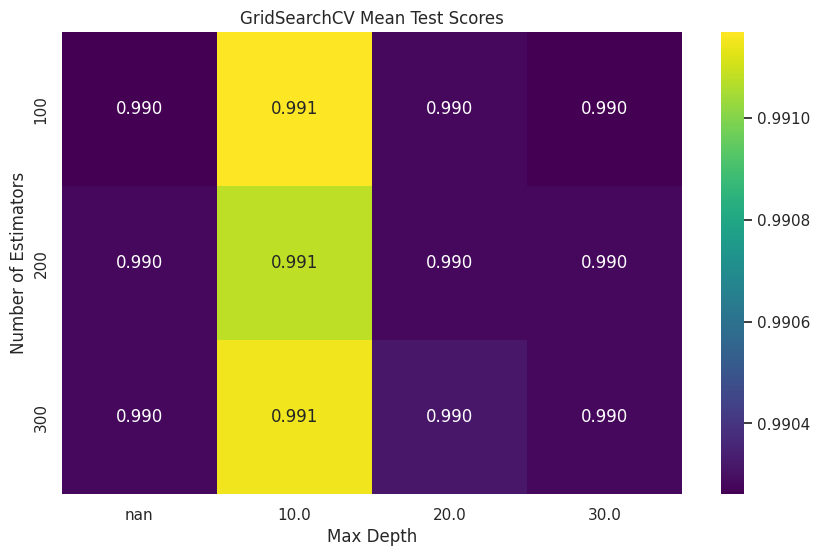

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert GridSearchCV results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Filter relevant columns
relevant_columns = ['param_n_estimators', 'param_max_depth', 'mean_test_score']
filtered_results = results[relevant_columns]

# Corrected pivot call
pivot_table = filtered_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')


# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('GridSearchCV Mean Test Scores')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()

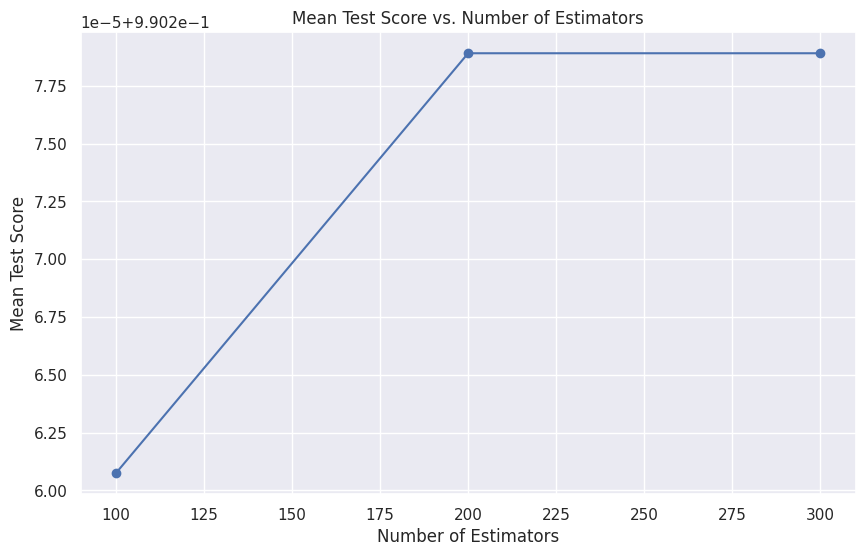

In [26]:
import matplotlib.pyplot as plt

# Assuming 'results' is the DataFrame containing GridSearchCV results
# Extracting mean test scores for a varying 'n_estimators'
n_estimators_scores = results[results['param_max_depth'].isnull()][['param_n_estimators', 'mean_test_score']]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_scores['param_n_estimators'], n_estimators_scores['mean_test_score'], marker='o')
plt.title('Mean Test Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

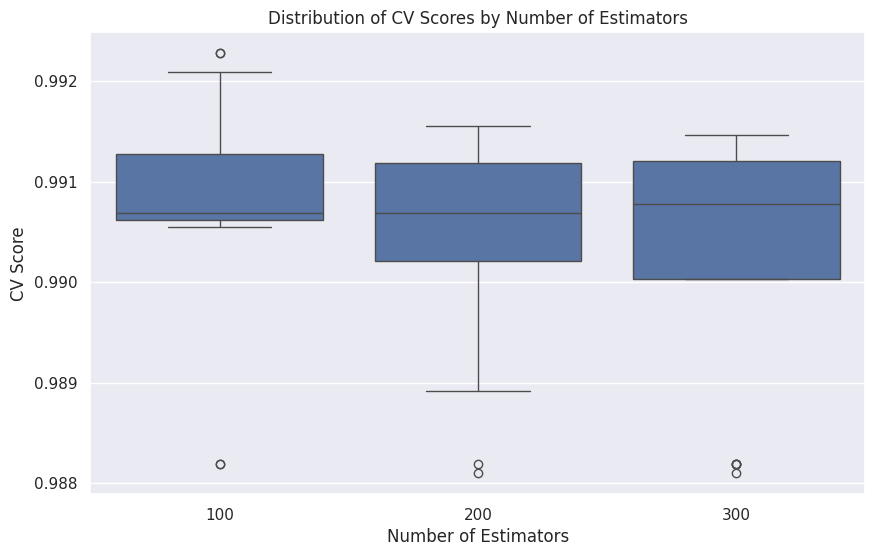

In [27]:
import seaborn as sns

# Create a DataFrame for box plot data
box_plot_data = pd.DataFrame({
    'n_estimators': np.repeat(results['param_n_estimators'], 5),  # Assuming 5-fold CV
    'score': np.concatenate([results[f'split{i}_test_score'] for i in range(5)])
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='n_estimators', y='score', data=box_plot_data)
plt.title('Distribution of CV Scores by Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('CV Score')
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np

def ResultPrintout(model):
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_important_val)
    true_labels = y_val
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(y_val, predictions, digits=5)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy}")
    
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels))
    print(model_report)


Validation Accuracy: 0.9904061052057781
              precision    recall  f1-score   support

           0    0.98391   0.99717   0.99050      9200
           1    0.99712   0.98360   0.99031      9145

    accuracy                        0.99041     18345
   macro avg    0.99052   0.99039   0.99041     18345
weighted avg    0.99050   0.99041   0.99041     18345

Validation Accuracy: 0.9904061052057781


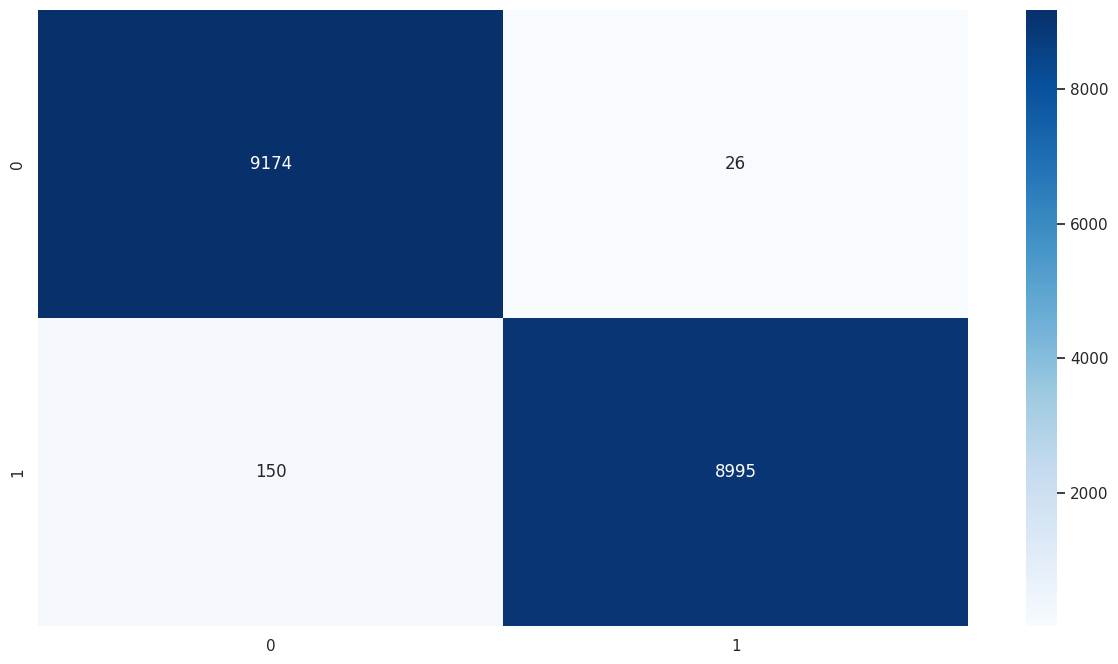

In [37]:
from sklearn.metrics import classification_report, accuracy_score
# Validation prediction and evaluation
y_val_pred = forest_important.predict(X_important_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
ResultPrintout(forest_important)
print(f"Validation Accuracy: {val_accuracy}")

In [22]:
def ResultPrintout(model):
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_important_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(y_test, predictions, digits=5)
    
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels))
    print(model_report)

              precision    recall  f1-score   support

           0    0.98392   0.99783   0.99083      9200
           1    0.99778   0.98360   0.99064      9146

    accuracy                        0.99073     18346
   macro avg    0.99085   0.99071   0.99073     18346
weighted avg    0.99083   0.99073   0.99073     18346



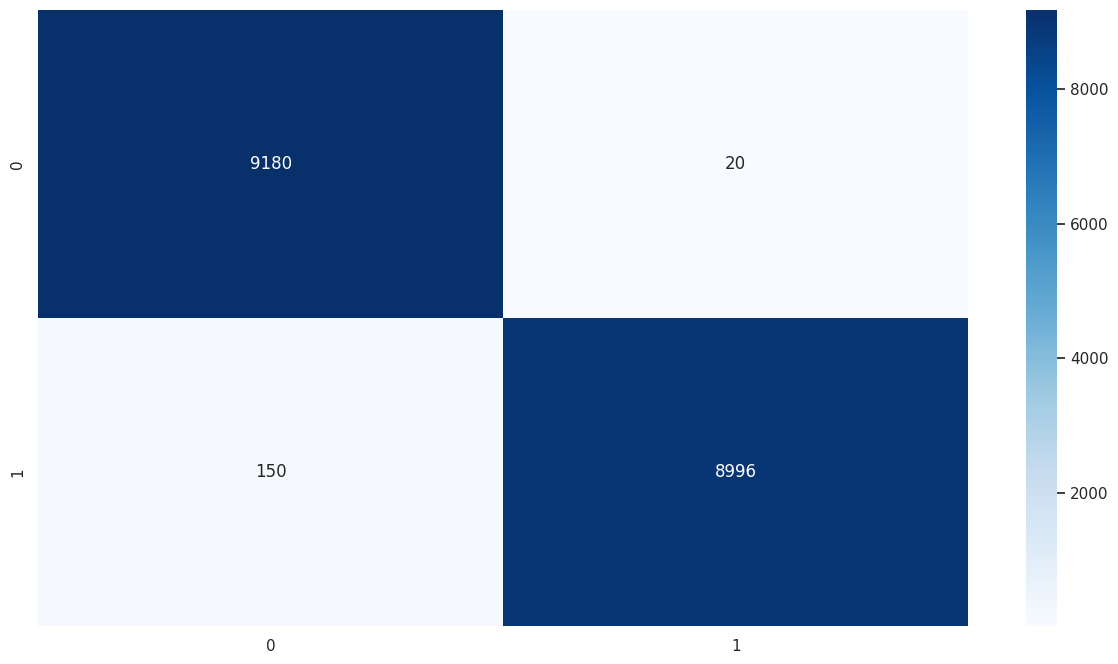

In [23]:
# Predictions and evaluation selected
y_pred = forest_important.predict(X_important_test)
ResultPrintout(forest_important)

In [24]:
import joblib

# Training the RandomForestClassifier with selected important features
forest_important = RandomForestClassifier(n_estimators=100, random_state=42)
forest_important.fit(X_important_train, y_train)

# Save the model to a file
model_filename = 'forest_important_model.pkl'
joblib.dump(forest_important, model_filename)

print(f'Model saved to {model_filename}')

Model saved to forest_important_model.pkl
[CV] END ...................max_depth=None, n_estimators=100; total time=   2.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   1.9s
[CV] END ...................max_depth=None, n_estimators=100; total time=   1.7s
[CV] END ...................max_depth=None, n_estimators=200; total time=   3.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=   3.7s
[CV] END ...................max_depth=None, n_estimators=300; total time=   5.3s
[CV] END ...................max_depth=None, n_estimators=300; total time=   5.5s
[CV] END ...................max_depth=None, n_estimators=300; total time=   5.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.7s
[CV] END .....................max_depth=10, n_estimators=200; total time=   3.2s
[CV] END .....................max_depth=10, n_estimators=200; total